In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from fastai.vision.all import *
from fastai.distributed import *

import fastai
import sklearn.metrics as skm

%matplotlib inline

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', None)

import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2
import scipy.io as sio
import h5py



Bad key "text.kerning_factor" on line 4 in
/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Pixel-labeled dataset generated from tiles classified in 9 classes
### All pixels of each tile belongs to only one class ['STR','NOR', 'TUM','ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS' ] 


In [2]:
path =  Path('TSR-data/TSR-tiles')
path.ls()

(#12) [Path('TSR-data/TSR-tiles/models'),Path('TSR-data/TSR-tiles/valid'),Path('TSR-data/TSR-tiles/train'),Path('TSR-data/TSR-tiles/STR-mask.bmp'),Path('TSR-data/TSR-tiles/NOR-mask.bmp'),Path('TSR-data/TSR-tiles/TUM-mask.bmp'),Path('TSR-data/TSR-tiles/ADI-mask.bmp'),Path('TSR-data/TSR-tiles/BAC-mask.bmp'),Path('TSR-data/TSR-tiles/DEB-mask.bmp'),Path('TSR-data/TSR-tiles/LYM-mask.bmp')...]

In [3]:
files = get_image_files(path)

In [4]:
codes = ['STR','NOR', 'TUM','ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS' ] #order matters: 0,1,2 is reserved for stroma, normal epyt and tumoral epyt.


In [5]:
i = 200000
print(files[i], path)
np.array(Image.open('TSR-data/TSR-tiles/MUS-mask.bmp')).mean()

TSR-data/TSR-tiles/train/TSR-CRC-Training-set-part1/STR/TCGA-AG-A020-01Z-00-DX1-STR-2-9.jpg TSR-data/TSR-tiles


8.0

In [6]:
def save_mask(c):
    shape = (224, 224)
    path_mask = path/f"{c}-mask.bmp"
    print(path_mask)
    Image.fromarray(np.full(shape, codes.index(c)).astype(np.uint8)).save(path_mask)
    return

In [7]:
#for c in codes:
    #save_mask(c)

## Two additional pixel-labeled datasets: 
### TCT-TSR  differentiates only between tumor epyt and other tissue ['OTHER', 'TUM']
### Warwick differentiates also normal epyt ['OTHER','NOR', 'TUM']

In [8]:
path =  Path('TSR-data/pixel_labeled')
dataset_name = 'Warwick QU Dataset (Released 2016_07_08)' 
df_grade_Warwick = pd.read_csv(path/dataset_name/"Grade.csv", names = ['fn', 'patient_ID', 'type', 'grade'], skiprows = 1)
df_grade_Warwick.groupby(['type','grade']).first()

fn  patient_ID
type       grade                                                    
 benign     adenomatous                          testA_1           4
            healthy                             testA_10          10
 malignant  moderately differentiated           testA_13           7
            moderately-to-poorly differentated  testA_22          11
            poorly differentiated               testA_12          11

In [9]:

def save_new_mask(f: Path):
    new_mask = None
    if f.suffix == '.bmp': #convert to ['OTHER','NOR_E', 'TUM_E'] 
        dataset_name = 'Warwick QU Dataset (Released 2016_07_08)'
        mask_f = path/dataset_name/"mask"/f"{f.stem}_anno{f.suffix}" #'TSR-data/pixel_labeled/Warwick QU Dataset (Released 2016_07_08)/train_65_anno.bmp'
        # convert  non 0 values to 1 ['OTHER', 'TUM_E'] 
        new_mask = np.where(np.array(Image.open(mask_f)) > 0, 2, 0) 
        # convert non 0 values to 2 if epythelyum type is benign (otherwise 1 is malignant)
        epythelium_type = pd.read_csv(path/dataset_name/"Grade.csv", names = ['fn', 'patient_ID', 'type', 'grade'], skiprows = 1)
        t  = epythelium_type.loc[epythelium_type.fn == f.stem,'type']
        if t.str.contains('benign').any():
            new_mask = np.where(new_mask > 0, 1, 0)
        path_mask = path/dataset_name/"new_mask"/f"{f.stem}_anno{f.suffix}"
        Image.fromarray(new_mask.astype(np.uint8)).save(path_mask)
        crop(path/dataset_name/"new_mask", path_mask, 300, 300, k= 0)
    
    else: #convert to ['OTHER', 'TUM_E'] as this dataset does not have normal epythelium
        dataset_name = 'TSR-CRC-TSR-evaluation-set'
        mask_f = path/dataset_name/"mask"/f"mask{f.stem.replace('image','')}{f.suffix}" #TSR-data/pixel_labeled/TSR-CRC-TSR-evaluation-set/mask/mask-100049.jpg
        # convert  non 0 values to 1 ['OTHER', 'TUM_E'] 
        new_mask = np.where(np.array(Image.open(mask_f)) > 0, 2, 0) 
        path_mask = path/dataset_name/"new_mask"/f"mask{f.stem.replace('image','')}.bmp"
        Image.fromarray(new_mask.astype(np.uint8)).save(path_mask)
        crop(path/dataset_name/"new_mask", path_mask, 300, 300, k= 0)
    return new_mask

#generate and save new masks in disk, including regenerating correspoding tiles
save_mask = False
files = get_image_files(path, folders = 'image')
if save_mask:
    for f in files:
        save_new_mask(f)

## Segmentation of tissue in 9 classes 
### ['STR','NOR', 'TUM','ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS' ]

In [10]:

def label_func(f): 
    
    mask_f = None
    if f.suffix == '.bmp':
        dataset_name = 'Warwick QU Dataset (Released 2016_07_08)'
        mask_f = path/dataset_name/"new_mask"/f"{f.stem}_anno{f.suffix}" #'TSR-data/pixel_labeled/Warwick QU Dataset (Released 2016_07_08)/train_65_anno.bmp'
    else:
        dataset_name = 'TSR-CRC-TSR-evaluation-set'
        mask_f = path/dataset_name/"new_mask"/f"mask{f.stem.replace('image','')}.bmp" #TSR-data/pixel_labeled/TSR-CRC-TSR-evaluation-set/mask/mask-100049.jpg
   
    return mask_f 
    

In [11]:
def label_func_masks_9_class(f): 
    mask_f = None
    s = None
    try:
        s = [x for x in re.split('[/-]', str(f)) if x[:3] in codes][0][:3]
        mask_f = path/f"{s}-mask.bmp"
    except :
        print(f)
        
    return mask_f 

In [12]:
path =  Path('TSR-data/TSR-tiles')
files = get_image_files(path)
label_func_masks_9_class(files[i+200])

Path('TSR-data/TSR-tiles/STR-mask.bmp')

## calculate dataset stats (do not use imagenet_stats) 

In [13]:
calculate_stats = False
if calculate_stats:
    dls = SegmentationDataLoaders.from_label_func(
    path, bs=150, fnames = files, label_func = label_func, codes = codes, item_tfms = Resize(460))
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats) #([0.745341  , 0.49060953, 0.7466369 ], [0.17284355, 0.22938302, 0.1365517 ]) #TSR-CRC + Warwick QU
else: 
    tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
tissue_stats

([0.7700158, 0.6154052, 0.74566764], [0.19486967, 0.26420233, 0.19368471])

## create dataloaders

In [14]:
#splitter = FuncSplitter(lambda o: 'test' in Path(o).stem  )
splitter = FuncSplitter(lambda o: Path(o).parent.parent.parent.name == 'valid')
np.random.shuffle(files)
splitter(files)

((#383626) [0,1,2,3,4,5,6,7,8,9...],
 (#28833) [19,20,31,32,41,88,119,126,130,132...])

In [15]:
item_tfms = Resize(224)
aug = aug_transforms(mult=2, flip_vert=True, max_rotate=90., min_zoom=0.5, max_zoom=10, size = 224)
spots_datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   #get_items=files[:10000],
                   get_y=label_func_masks_9_class,
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms=[Normalize.from_stats(*tissue_stats), *aug])

In [16]:
sample = files[:412459]

print(sample, files)
print(splitter(sample))
dls = spots_datablock.dataloaders(sample, bs = 15) #change bs to 15 if one GPU only

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
#spots_datablock.summary(path)


In [18]:
#dls = SegmentationDataLoaders.from_label_func(
#    path, bs=12, fnames = files, label_func = label_func, codes = codes, item_tfms = Resize(300)
#)

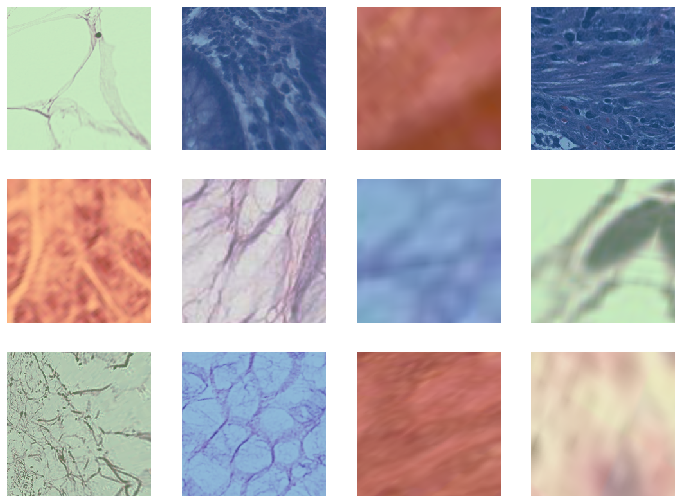

In [19]:
dls.show_batch(max_n = 12)

## U-net encoder 

In [ ]:
def foreground_acc_9_classes(inp, targ, bkg_idx= codes.index('BAC'), axis=1): #background idx should be 4
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    res = (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()
    if torch.isnan(res):
        print(targ.shape, mask.shape, inp.shape)
        print(inp.argmax(dim=axis)[mask]==targ[mask])
        return None
        
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

In [ ]:
encoder = resnet34
encoder = 'tissue-classifier-9-classes'

In [ ]:
learn = None
if encoder == resnet34:
    learn = unet_learner(dls, encoder, normalize = False, metrics = foreground_acc)
elif encoder == 'tissue-classifier-9-classes':
    learn_pretrained = cnn_learner(dls, resnet34, metrics=[error_rate,RocAuc()],normalize=False, n_out=9,
                                  path=Path("."))
    path1 = Path('models') 
    tissue_model = path1.ls()[1].with_suffix("").name     
    learn_pretrained.load(tissue_model)
    m_tissue_classifier =  learn_pretrained.model
    m_tissue_classifier = list(m_tissue_classifier.children())[0]
    size = (224,224)
    m = DynamicUnet(m_tissue_classifier, 9, size, norm_type=None) #retrain  n-out = 9 
    x = torch.randn(2, 3, 224, 224)
    y = m(x)
    test_eq(y.shape, [2, 9, 224, 224])
    learn = Learner(dls, m, normalize = False, metrics = foreground_acc_9_classes)# cbs = CutMix(alpha=1.))
 

In [ ]:
learn.load(f'segment_tissue_9_class' )
learn.validate(ds_idx=1)

In [ ]:
#learn.fine_tune(11, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))
#learn.to_parallel()
#learn.fine_tune(1)

In [ ]:
loss_val, foreground_acc = learn.final_record
#learn.save(f'segment_tissue_9_class_{loss_val}_f_acc_{foreground_acc}' )



In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

In [ ]:
sample = learn.dls[1].dataset[:100]
dls_small = spots_datablock.dataloaders(path, bs = 15, sample = sample)
interp = Interpretation.from_learner(learn, ds_idx = 1, act =None )

In [ ]:
i = 3
learn.dls[1].dataset[i][0].show()
show_image(interp.targs[i])
print(interp.targs[i].median(), interp.decoded[i].median() )
show_image(interp.decoded[i])
foreground_acc(interp.preds[i], interp.targs[i], axis = 0)


In [ ]:
file = 'testA_12'
f =  Path(f'TSR-data/pixel_labeled/image/{file}.bmp')
#f = Path('TSR-data/pixel_labeled/image/image-100049.jpg')
show_image(Image.open(label_func(f)), title=0)
cam_img = PILImage.create(f)
tmask = Transform(PILMask.create)
mask = tmask(label_func(f))
test_eq(type(mask), PILMask)
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);
np.array(mask)

In [ ]:
i = 2
print(files[i])
p = files[i]
file = 'testA_12'
p =  Path(f'TSR-data/pixel_labeled/image/{file}.bmp')
mask_f = label_func(p)
show_image(Image.open(p), title=0)
show_image(Image.open(mask_f), title=0)

In [ ]:
np.array(Image.open(p)).shape

In [ ]:
learn.get_preds(Image.open(files[0]))

In [ ]:
#pending 1) augmentation, mixup